In [1]:
import pandas as pd 
import os
from utils.explanations import minmax_norm
from utils.utils import read_dataset
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from utils.explanations import calculate_cam_attributions
import matplotlib.pyplot as plt

import tensorflow_addons as tfa
#from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.utils import CustomObjectScope

data_p = 'G:/Meine Ablage/master thesis/code/xai-tsc'
archive = 'ucr'
dataset_name = 'GunPoint'
data_source = 'original'
ylen = 1
data = read_dataset(data_p, archive, dataset_name,  data_source, ylen)[dataset_name]
data_source = 'fcn_raw'
ylen = len(data[0][0])

data_1 = read_dataset(data_p, archive, dataset_name,  data_source, ylen)[dataset_name]


print(data_1[2])

def load_model(root_dir, archive_name, dataset_name, classifier, data_source): 
    with CustomObjectScope({'InstanceNormalization':tfa.layers.InstanceNormalization()}):
        model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                                + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                                + f'last_model.hdf5'
        model =keras.models.load_model(model_path ,compile=False)
        return model

#G:\Meine Ablage\master thesis\code\xai-tsc\results\ucr\Coffee\fcn\fcn_mt_relus_0.0\fcn_cam_raw
root_dir ='G:/Meine Ablage/master thesis/code/xai-tsc'
archive_name = 'ucr'
classifier = 'fcn_1.0'#'fcn_mt_dense_0.0' #'fcn_1.0' #'fcn_1.0'#'fcn_mt_dense_0.5'
data_source = 'original'#'fcn_raw_mse'#'original'#'fcn_raw_mse'
dataset_name = 'GunPoint'

_,_,x,y=data
_,_,x1,y1 = data_1
model = load_model(root_dir, archive_name, dataset_name, classifier, data_source)

model(x)
print(np.unique(y))
y = y-1
print(np.unique(y))

c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


[[-1.125   -1.1313  -1.1383  ... -1.2127  -1.2062  -1.2184 ]
 [-0.62696 -0.62592 -0.62754 ... -0.61947 -0.61206 -0.60642]
 [-2.0012  -1.9996  -1.9995  ... -0.81272 -1.0711  -1.3234 ]
 ...
 [-0.73801 -0.7363  -0.73123 ... -0.60965 -0.60862 -0.61218]
 [-1.2651  -1.2561  -1.2594  ... -1.2     -1.1934  -1.1928 ]
 [-1.4272  -1.4083  -1.3471  ... -1.1035  -1.1531  -1.222  ]]
[1. 2.]
[0. 1.]


In [5]:
from scipy.interpolate import interp1d
def prepare_visualize_attribution(ts,attribution):
    max_length = 2000    
    #prepare values
    minimum = np.min(attribution)
    cas = attribution - minimum
    cas = cas / max(cas)
    cas = cas * 100
    xv= np.linspace(0, len(ts) - 1, max_length, endpoint=True)
    f = interp1d(range(len(ts)),ts)
    yv = f(xv)
    f = interp1d(range(len(ts)),cas)
    cas = f(xv).astype(int)
    return xv,yv,cas

0
0
0
0


NameError: name 'prepare_visualize_attribution' is not defined

<Figure size 640x480 with 0 Axes>

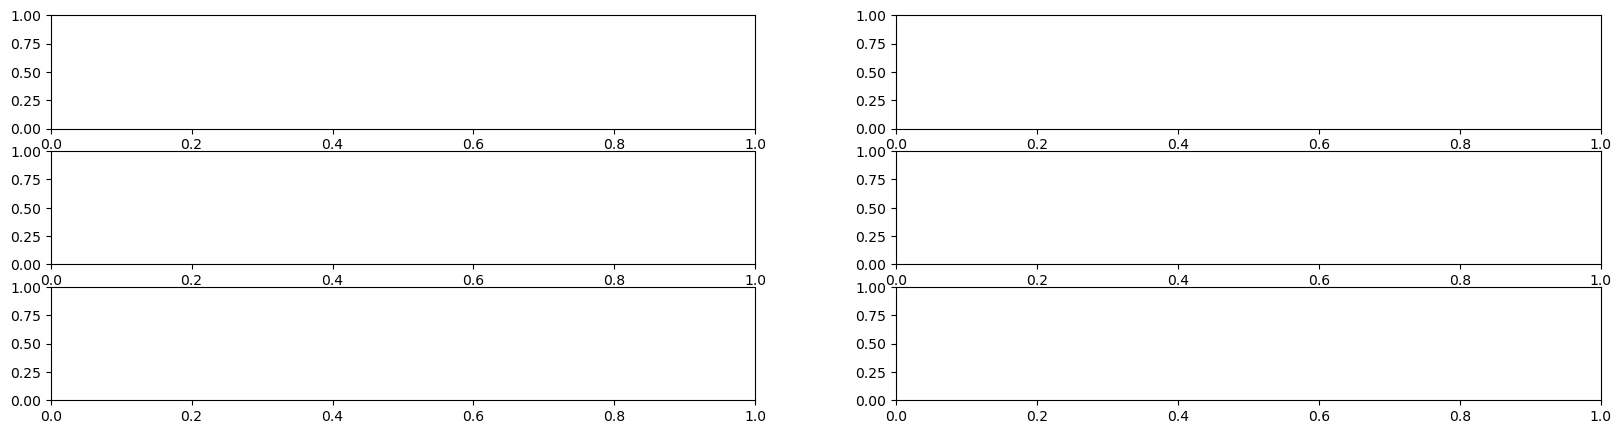

In [4]:
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
import tensorflow as tf 
def interpolate_series(baseline,
                       series,
                       alphas):
  alphas_x = alphas[:,tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(series, axis=0)
  delta = tf.expand_dims((series - baseline),axis=0)
  series = baseline_x +  alphas_x * delta
  return series

def compute_gradients(series,target_class_idx,task=0):
  with tf.GradientTape() as tape:
    tape.watch(series)

    logits = model(series)[0]
    tf.print(tf.math.argmax(logits))
    #tf.print(logits.shape)
    #tf.print(logits)
    #tf.print(logits)
    target_class_idx = int(target_class_idx[0])
    #logits = logits[:,target_class_idx]
    #probs = tf.nn.softmax(logits,axis=-1)[:,target_class_idx]
    #tf.print(probs.shape)
  return tape.gradient(logits, series)

def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

@tf.function
def integrated_gradients(baseline,
                         series,
                         target_class, 
                         m_steps=50,
                         batch_size=16,
                         task = 0):
  # 1. Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
  #tf.print("ALPHAS",alphas)
  # Initialize TensorArray outside loop to collect gradients.    
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_series(baseline=baseline,
                                                       series=series,
                                                       alphas=alpha_batch)


    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(interpolated_path_input_batch,target_class,task=task)

    
    #tf.print(gradient_batch)

    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    

  # Stack path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()

  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  #print("AVG",(series - baseline,tf.print(avg_gradients)))
  # 5. Scale integrated gradients with respect to input.
  integrated_gradients = (series - baseline) * avg_gradients

  #tf.print(series - baseline)
  #tf.print(integrated_gradients)

  return integrated_gradients

plt.figure()

fig,ax = plt.subplots(nrows=3,ncols=2, figsize=(20,5))

prediction=model(x)[1] 


corr = 0 

for ts in range(8): 
  #
  # ts = 15
  ts  += 10
  avg = np.average(x, axis=0)
  avg = tf.convert_to_tensor(avg, dtype = np.float64)

  mean = np.median(x[ts])
  
  #print(int(mean))
  baseline = tf.zeros(len(x[0]))
  #tf.convert_to_tensor(x[4].astype('float32'))
  #tf.zeros(len(x[0]))#avg#tf.zeros(len(x[0]))#avg#tf.zeros(150)
  series = x[ts]
  #print(type((y[ts]-1)[0]))
  ig_att = integrated_gradients(baseline,series.astype('float32'),target_class=y[ts],task=1)

  #print(np.max(ig_att),np.sum(ig_att))

  idx = 1
  
  cam_att = calculate_cam_attributions(root_dir, archive_name, classifier, dataset_name, data_source)[idx]

  cam_att = cam_att[ts][2]

  #print(ig_att.shape, cam_att.shape)

  #
  # print("CORR",np.corrcoef(ig_att,y1))
  #corr += np.corrcoef(ig_att,prediction[ts].numpy().flatten())
  #np.corrcoef(y1[ts], prediction[ts].numpy().flatten())#y1[ts]) 
  #cosine_similarity(ig_att.numpy().reshape(-1, 1),cam_att.reshape(-1, 1))
  #np.corrcoef(ig_att, cam_att)
  #np.corrcoef(ig_att, cam_att)

  cam_vis = prepare_visualize_attribution(x[ts],cam_att)
  #curr_vis = prepare_visualize_attribution(x[ts], y1[ts])
  ig_vis = prepare_visualize_attribution(x[ts],ig_att)
  #print(np.corrcoef(value,cam_att))


  #plt.scatter(ig_vis[0],ig_vis[1],c=ig_vis[2], cmap='jet',  vmin=0,vmax=100)
  #print(x[ts].shape,prediction[ts].shape)
  pred_vis = prepare_visualize_attribution(x[ts],prediction[ts].numpy().flatten())
  
  #pred_vis = [0]*150
  trained_vis = prepare_visualize_attribution(x[ts],y1[ts])

  corr += np.corrcoef(ig_vis[2],trained_vis[2])

  ax[0][0].scatter(cam_vis[0],cam_vis[1],c=cam_vis[2], cmap='jet', vmin=0,vmax=100)
  ax[0][1].scatter(ig_vis[0],ig_vis[1],c=ig_vis[2], cmap='jet',  vmin=0,vmax=100)
  ax[1][0].scatter(pred_vis[0],pred_vis[1],c=pred_vis[2], cmap='jet', vmin=0,vmax=100)
  ax[1][1].scatter(pred_vis[0],pred_vis[1],c=pred_vis[2], cmap='jet',  vmin=0,vmax=100)
  ax[2][0].scatter(trained_vis[0],trained_vis[1],c=trained_vis[2], cmap='jet', vmin=0,vmax=100)
  ax[2][1].scatter(trained_vis[0],trained_vis[1],c=trained_vis[2], cmap='jet',  vmin=0,vmax=100)
  #ax[2].scatter(curr_vis[0],curr_vis[1],c=curr_vis[2], cmap='jet')




#print(np.corrcoef(cam_att,pred_vis[0]))
plt.tight_layout()
plt.show()

In [23]:
print(y1)

[[-1.49776769e-09 -2.67733546e-09 -2.69518696e-09 ...  6.66798734e-12
  -1.10177721e-10 -5.90153093e-10]
 [-3.56787877e-10 -5.51234169e-10 -4.84559559e-10 ... -5.46995504e-10
  -3.37843475e-10  2.70497687e-11]
 [-5.64289032e-11 -1.56429314e-09 -3.22169580e-09 ... -8.19447080e-11
  -1.32993516e-09 -1.11992704e-09]
 ...
 [-4.83319704e-11 -3.38740258e-10 -5.77473458e-10 ...  2.25670438e-09
   2.60009769e-09  1.80466153e-09]
 [-1.16396315e-09 -2.02949924e-09 -2.24896302e-09 ... -3.90643695e-09
  -2.24541608e-09  7.15209281e-11]
 [-1.27658251e-09 -1.34127986e-09 -5.11431619e-10 ... -2.07738116e-09
  -3.30030203e-09 -2.70785683e-09]]


Y02 [[1.         0.66785292]
 [0.66785292 1.        ]] [[1.         0.84197261]
 [0.84197261 1.        ]]
[[1.         0.01235535]
 [0.01235535 1.        ]]


ZeroDivisionError: division by zero

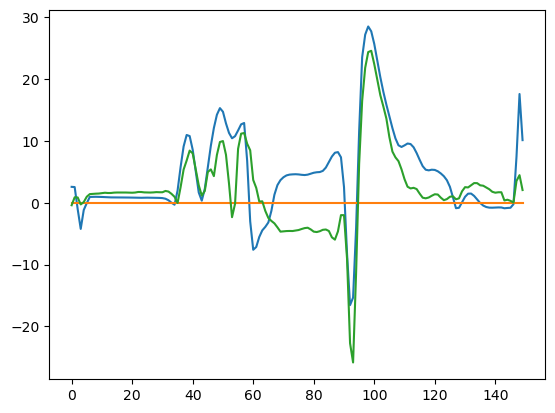

In [33]:
ts = 5

y0 = 0 
y11 = 0 
sim0 = 0
sim1 =  0
sim2 = 0
sim = 0
nr  = None

#print(np.corrcoef(igs,y1[ts]))
c = 0 
for i in range(len(y)):
    igs = integrated_gradients(baseline,x1[i].astype('float32'),target_class=y[ts],task=1)
    if y[i] == 0:
        c += 1
        sim0 += np.corrcoef(igs,y1[i]) 
        if np.corrcoef(igs,y1[i])[0,1] > sim: nr = i; sim = np.corrcoef(igs,y1[i])[0,1]
        y0 += np.corrcoef(prediction[i].numpy().flatten(),y1[i]) 
    elif y[i] == 1: 
        sim1 += np.corrcoef(igs,y1[i]) 
        if np.corrcoef(igs,y1[i])[0,1] > sim: nr = i; sim = np.corrcoef(igs,y1[i])[0,1]
        np.corrcoef(igs,y1[i])         
        y11 += np.corrcoef(prediction[i].numpy().flatten(),y1[i]) 
    else:
        print(sim,np.corrcoef(igs,y1[i])[0,1])
        if np.corrcoef(igs,y1[i])[0,1] > sim: nr = i; sim = np.corrcoef(igs,y1[i])[0,1]
        sim2 += np.corrcoef(igs,y1[i]) 


#print(y[ts])
ts = 10

#print(np.corrcoef(igs,prediction[ts].numpy().flatten()))
#print(np.corrcoef(y1[ts],prediction[ts].numpy().flatten()))

plt.plot(y1[ts])
plt.plot(igs)
plt.plot(prediction[ts])

print("Y02",y0/c,y11/(len(y)-c))
print(sim0/c)
#print(sim1/len(y[y==(1)]))
print(sim2/len(y[y==(-1)]))

print(y[ts])

In [538]:
len(y[y==(1)])

20

[1.]
[[1.         0.44226888]
 [0.44226888 1.        ]]


ValueError: y has more than 2 dimensions

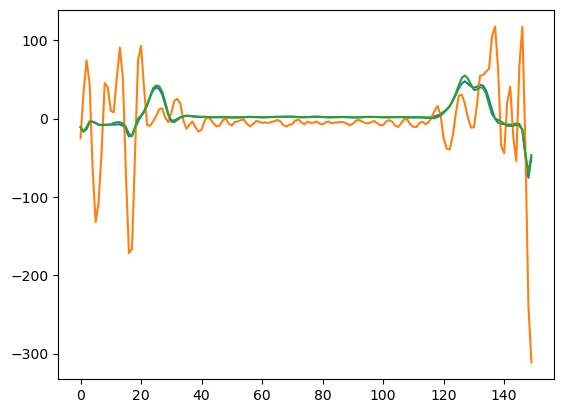

In [9]:
ts = 35
print(y[nr])
#print(np.corrcoef(igs,prediction[ts].numpy().flatten()))
#print(np.corrcoef(y1[ts],prediction[ts].numpy().flatten()))

#print(y1[ts])
plt.plot(y1[nr])
plt.plot(integrated_gradients(baseline,x1[nr].astype('float32'),target_class=y[nr],task=1))
plt.plot(prediction[nr])

print(np.corrcoef(integrated_gradients(baseline,x1[nr].astype('float32'),target_class=y[ts],task=1), y1[nr]))
print(np.corrcoef(y1[nr],[prediction[nr]]))
#print("Y02",sim0/c)
#print(sim1/(len(y)-c))

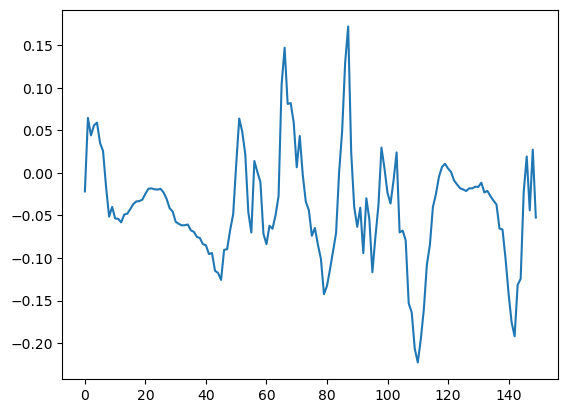

In [253]:
plt.figure()

plt.plot(ig_att)
#plt.plot(y[ts])
plt.show()

In [255]:
np.corrcoef(ig_att, y1[ts])

array([[1.        , 0.18267256],
       [0.18267256, 1.        ]])

In [145]:
model(x)[0]




<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9945018 , 0.00549819], dtype=float32)>

In [178]:
corr 

0.8668750747200995

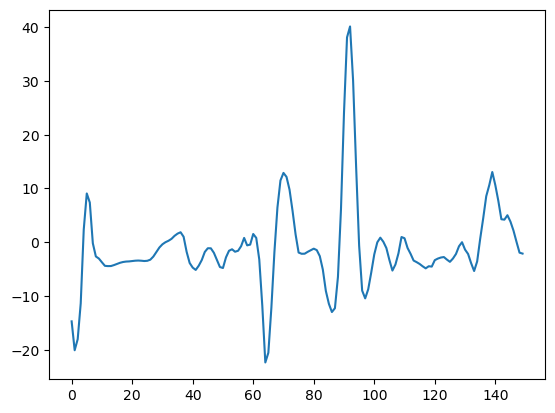

In [181]:
plt.plot(ig_att)

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

np.corrcoef(ig_att,prediction[ts].numpy().flatten())
cam = calculate_cam_attributions(root_dir, archive_name, classifier, dataset_name, data_source)[idx]
m = 0
s = 0
for ts in range(len(prediction)): 
    print(m)
    ig = integrated_gradients(baseline,x[ts].astype('float32'),task=1)
    cm = cam[ts][2]
    if np.isnan(m): 
        break 
    #print(np.corrcoef(prediction[ts].numpy().flatten(),integrated_gradients(baseline,x[ts].astype('float32'),task=1))[0,1])
    if np.isnan(np.corrcoef(prediction[ts].numpy().flatten(),ig )[0,1]):
        #print(integrated_gradients(baseline,x[ts].astype('float32'),task=0))
        break
    m+=np.corrcoef(prediction[ts].numpy().flatten(),ig)[0,1]
    s+=np.corrcoef(prediction[ts].numpy().flatten(), y1[ts])[0,1]

print(m/len(prediction))
print(s/len(prediction))

0
-0.06957504509090316
-0.23091805771246138
-0.24704561409556838


c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


-0.2743503040158213
-0.37849966526666556
-0.5909825599860128
-0.41657701305978545
-0.7200081671497821
-0.5755450944162771
-0.8036192857562391
-0.7093940797359115
-0.6970925572932756
-0.7654569127052511
-0.6495365805503404
-0.5127195121411173
-0.43225641268931125
-0.5568836511072206
-0.7733135891303271
-0.9760955671157089
-1.0655996537445604
-1.1090855757048255
-1.4864649533576417
-1.572405030406143
-1.7461214511505683
-1.772003018972348
-1.9490972193029146
-1.9232124280948133
-1.9536764244128664
-2.187368733093483
-2.279627646316634
-2.5088462060254213
-2.8802203185315713
-3.1058815902870363
-3.4181401246021905
-3.5649978935297164
-3.5925345064327203
-3.7125409452389913
-3.7055647289553475
-3.7623698975897315
-4.111566678488948
-4.209440534776511
-4.3852925611226
-4.316754633813261
-4.315711257276756
-4.47700279754401
-4.271709357620002
-4.628703170651072
-4.805982974384768
-4.836278705805336
-4.7492304957872244
-4.946808759895157
-4.947998915690198
-5.036138315847434
-5.02358696956988

In [23]:
y1[3]

array([-9.91019281e-11, -9.13972439e-11, -1.77814048e-11,  7.83400150e-11,
        1.24040361e-10,  1.02970875e-10,  4.60597289e-11, -2.51747304e-11,
       -3.19622454e-11, -1.74931285e-11,  2.06086554e-11,  7.46999892e-11,
        2.14776127e-10,  4.96011732e-10,  7.42384709e-10,  7.82246323e-10,
        5.98496752e-10,  2.13125795e-10, -1.24023861e-10, -2.49890275e-10,
       -2.56674321e-10, -2.52618704e-10, -2.35125808e-10, -2.81997758e-10,
       -3.30312333e-10, -4.10478179e-10, -4.15893348e-10, -3.42389783e-10,
       -2.94048091e-10, -2.37767250e-10, -2.45106602e-10, -2.79552131e-10,
       -3.46937978e-10, -3.45819429e-10, -2.98755298e-10, -2.75249462e-10,
       -1.80548659e-10, -1.66410261e-10, -2.77311507e-10, -3.98475003e-10,
       -4.36402692e-10, -4.47812842e-10, -2.96063563e-10, -1.52495350e-10,
       -2.10821464e-11, -5.39579180e-11, -4.14740103e-10, -7.34081795e-10,
       -6.90553725e-10, -2.11075574e-10,  4.80115392e-10,  9.84663351e-10,
        6.95896452e-10, -

In [52]:
print(m)

nan


In [9]:
print(y[ts])

[0.]


1/1 [==============================] - 0s 17ms/step
[[9.905484e-04 9.990094e-01]]


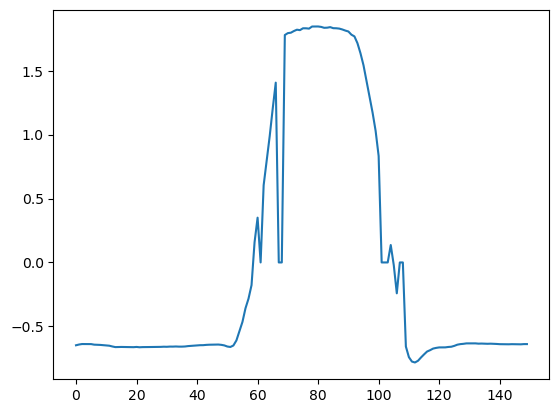

In [121]:
att_type = ig_att
keep = 0.95
sorted = (np.argsort(att_type)[::-1][int(len(att_type)*keep):])

supp_x = x[ts].copy()
supp_x[sorted] = 0
supp_x = np.expand_dims(supp_x,axis=0)

print(model.predict(supp_x))

plt.plot(supp_x.T)

In [167]:
len(ig_vis[2][ig_vis[2]<50])

1645

In [62]:
y1[ts]

array([-2.03207229e+00, -1.44007541e+00,  1.10518397e-01,  5.55619619e-01,
        5.50262708e-01,  5.90089668e-01,  5.11317340e-01,  4.99121594e-01,
        4.78800408e-01,  4.43015744e-01,  4.14235061e-01,  4.19502594e-01,
        4.54197712e-01,  4.85848765e-01,  5.04312037e-01,  5.09782731e-01,
        5.06846271e-01,  5.02328016e-01,  4.98578825e-01,  4.98920293e-01,
        5.02563639e-01,  5.06731786e-01,  5.10576323e-01,  5.14474282e-01,
        5.17080883e-01,  5.21110183e-01,  5.25982175e-01,  5.29913048e-01,
        5.31850770e-01,  5.31172847e-01,  5.29053311e-01,  5.28641122e-01,
        5.32617478e-01,  5.41244425e-01,  5.54708850e-01,  5.69967030e-01,
        5.82533002e-01,  5.89720861e-01,  5.91515941e-01,  5.90078029e-01,
        5.88457959e-01,  5.87357380e-01,  5.84981769e-01,  5.79008153e-01,
        5.64390447e-01,  5.37422591e-01,  5.07192760e-01,  5.00210484e-01,
        5.25761299e-01, -8.62014538e-03, -4.80519164e+00, -1.07570759e+01,
       -1.48761916e+01, -

In [53]:
print(cam_att)

[-0.96433  -0.96426  -0.96477  -0.96309  -0.96376  -0.96239  -0.962
 -0.96154  -0.96097  -0.95563  -0.95475  -0.95381  -0.94986  -0.94671
 -0.95005  -0.9431   -0.91262  -0.8506   -0.76758  -0.67859  -0.62965
 -0.61139  -0.61473  -0.62927  -0.62442  -0.59615  -0.57529  -0.56127
 -0.53517  -0.50789  -0.48563  -0.4736   -0.45091  -0.41557  -0.38558
 -0.32147  -0.2364   -0.10262   0.05185   0.23966   0.46068   0.62007
  0.76559   0.90351   1.0267    1.1392    1.2382    1.3085    1.3628
  1.4004    1.416     1.4184    1.4134    1.4135    1.4175    1.4203
  1.4264    1.4337    1.4329    1.4278    1.4338    1.4325    1.419
  1.4285    1.4263    1.425     1.4297    1.4332    1.4302    1.4345
  1.4328    1.4421    1.4423    1.4477    1.4479    1.4439    1.4439
  1.443     1.4451    1.4387    1.4352    1.4276    1.4273    1.4128
  1.3831    1.3373    1.2889    1.2196    1.1309    1.0266    0.88836
  0.73476   0.54673   0.37844   0.20131   0.023965 -0.11019  -0.25447
 -0.36629  -0.46337  -0.52737

array([-0.64443 , -0.6454  , -0.64706 , -0.64749 , -0.64691 , -0.64388 ,
       -0.63973 , -0.63809 , -0.6353  , -0.63538 , -0.63411 , -0.63372 ,
       -0.63205 , -0.63228 , -0.62956 , -0.6287  , -0.62747 , -0.62409 ,
       -0.62038 , -0.61557 , -0.61236 , -0.60895 , -0.60814 , -0.60875 ,
       -0.60932 , -0.60964 , -0.61068 , -0.61113 , -0.61108 , -0.61171 ,
       -0.61088 , -0.60945 , -0.60894 , -0.60689 , -0.60496 , -0.60258 ,
       -0.60001 , -0.59801 , -0.59754 , -0.59777 , -0.59699 , -0.59715 ,
       -0.59554 , -0.59359 , -0.59578 , -0.59911 , -0.59121 , -0.56584 ,
       -0.50726 , -0.47291 , -0.39633 , -0.33415 , -0.2     , -0.084494,
        0.10084 ,  0.31489 ,  0.52512 ,  0.69455 ,  0.80781 ,  0.92774 ,
        1.0859  ,  1.2465  ,  1.4187  ,  1.5884  ,  1.7182  ,  1.8249  ,
        1.8472  ,  1.8518  ,  1.8724  ,  1.8872  ,  1.8986  ,  1.9094  ,
        1.9125  ,  1.9097  ,  1.9175  ,  1.919   ,  1.919   ,  1.9252  ,
        1.9172  ,  1.92    ,  1.9212  ,  1.9229  , 